# Plotting and Analyzing Lightcurves of Eclipsing Binary Stars with `lightkurve`

***

## Learning Goals

By the end of this tutorial, you will:

- Download and plot a lightcurve file using `astroquery.mast`.
- Download and plot a collection of the lightcurves using `lightkurve`.
- Create a periodogram of a collection of lightcurves to find the possible eclipsing binary period. 

This is Part 2 of a two-part tutorial. In a separate notebook for Part 1, `find_eclipse_candidates`, we used Vizier to select our binary star system candidate from a catalog created using the radial velocity method and confirmed that it had multiple TESS lightcurves in the MIT Quick-Look Pipeline ("QLP") archive. 

## Introduction

From Part 1 of this tutorial:

>The [Apache Point Observatory Galactic Evolution Experiment 2 (APOGEE-2)](https://www.sdss.org/surveys/apogee-2/), observed near-infrared spectra of hundreds of thousands of stars in our Milky Way. This survey was used to search for stars whose spectral lines showed the tell-tale radial velocity changes associated with stellar binaries. Near the end of the APOGEE-2 survey, the [Transiting Exoplanet Survey Satellite (TESS)](https://tess.mit.edu/) was launched to search for exoplanets using the transit method; eclipses of primary stars by binary stars would also be observable by TESS. Finding a stellar system that has been observed by both surveys would provide confirmation of the properties of the system. 

>In this tutorial, we will load a catalog of binary stellar systems discovered through the radial velocity method and investigate if those systems also have lightcurves in the MAST archive from the TESS mission. Two sources for those already processed lightcurves are the TESS Data for Asteroseismology Lightcurves archive from TASOC (the TESS Asterosesmic Science Operations Center) or in the TESS Lightcurves From The MIT Quick-Look Pipeline ("QLP") archive. Though we'll focus on a narrow set of eclipsing binaries with previously-measured properties, the radial velocity catalog we'll be working with has nearly 5000 stellar systems that are yet to be fully characterized. 

Now, we'll actually view and analyze the lightcurves for just one of the radial velocity-selected stellar systems to see if we can observe an eclipse in the TESS data.

## Imports

- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data
- *astroquery.mast Observations* for querying MAST for observations
- *lightkurve* for plotting and analying TESS lightcurves from the QLP or TASOC archives hosted on MASS

You may need to [install the ```lightkurve``` package using its quickstart guide](https://docs.lightkurve.org/quickstart.html). 

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from astroquery.mast import Observations
import lightkurve as lk

***

## Examining and Plotting the Lightcurve .fits File

In Part 1 of the tutorial, we decided to investigate the binary star system located at RA = 2.238636 degrees, Dec = 73.690475 degrees. The period determined by the analysis of [Price-Whelan et al. 2018 (AJ, 156, 1, 18)](https://ui.adsabs.harvard.edu/abs/2018AJ....156...18P/abstract) was 83.66193 days. For now, we'll enter that information manually and then use astroquery to search for the QLP observations

In [2]:
coordstring='2.238636 73.690475'
per=83.66193
obs_tbl = Observations.query_region(coordstring,radius=0.008)
obs_tbl=obs_tbl[obs_tbl['provenance_name']=='QLP']
print(obs_tbl)

intentType obs_collection provenance_name instrument_name ... mtFlag srcDen  obsid   distance
---------- -------------- --------------- --------------- ... ------ ------ -------- --------
   science           HLSP             QLP      Photometer ...  False    nan 39201475      0.0
   science           HLSP             QLP      Photometer ...  False    nan 38106544      0.0
   science           HLSP             QLP      Photometer ...  False    nan 34983240      0.0
   science           HLSP             QLP      Photometer ...  False    nan 34099561      0.0


Our ```obs_tbl``` table from ```astroquery``` includes a column called "dataURL." With this URL, we can directly download the lightcurve file in .fits format to the harddrive. If it is successfully, 'COMPLETE' will appear as the first output. It will automatically download into the current working directory, unless the ```local_path``` option is set. Also, by default, the file will not download again if the file is already found on the harddrive. To see how to change this and other settings you can [view the ```Observations.download_file``` documentation](https://astroquery.readthedocs.io/en/latest/api/astroquery.mast.ObservationsClass.html#astroquery.mast.ObservationsClass.download_file). To download multiple files at once, use ```Observations.download_products``` instead.  

In [3]:
url=obs_tbl[0]['dataURL']
Observations.download_file(url)
# JRK this is actually uri not URL? Confused. 

INFO: Found cached file /Users/julia/GitHub/notebooks-stsci/notebooks/MAST/plot_analyze_with_lightkurve/hlsp_qlp_tess_ffi_s0018-0000000373283207_tess_v01_llc.fits with expected size 72000. [astroquery.query]


('COMPLETE', None, None)

We can use ```fits``` from ```astropy``` to examine the lightcurve file. The filename will be the last part of the url string, when separated by slashes.

In [4]:
filename=url.split('/')[-1]
lcfits=fits.open(filename)
lcfits.info()

Filename: hlsp_qlp_tess_ffi_s0018-0000000373283207_tess_v01_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  LIGHTCURVE    1 BinTableHDU     65   1107R x 13C   [D, J, E, E, E, J, J, E, E, E, E, E, E]   


The TESS lightcurve file has two extensions:

- No. 0 (Primary): This HDU (Header Data Unit) contains metadata related to the entire file.
- No. 1 (Light Curve): This HDU contains a binary table that holds data like flux measurements and times. We will extract information from here when we define the parameters for the light curve plot.

We can preview the contents of the second file extension by examining the names of the columns and the first few lines of data.

In [5]:
print(lcfits[1].columns)
print(lcfits[1].data[0:5])

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD-2457000, days'
    name = 'CADENCENO'; format = 'J'
    name = 'SAP_FLUX'; format = 'E'
    name = 'KSPSAP_FLUX'; format = 'E'
    name = 'KSPSAP_FLUX_ERR'; format = 'E'
    name = 'QUALITY'; format = 'J'
    name = 'ORBITID'; format = 'J'
    name = 'SAP_X'; format = 'E'; unit = 'pixel'
    name = 'SAP_Y'; format = 'E'; unit = 'pixel'
    name = 'SAP_BKG'; format = 'E'
    name = 'SAP_BKG_ERR'; format = 'E'
    name = 'KSPSAP_FLUX_SML'; format = 'E'
    name = 'KSPSAP_FLUX_LAG'; format = 'E'
)
[(1790.68018644, 27034, 0.9677139 , 1.0017732, 0.00369792, 4096, 43, 171.42014, 1276.1276, 623.68, 1048.87, 1.000957 , 1.0035249 )
 (1790.70102002, 27035, 0.9719843 , 1.0031046, 0.00369792, 4096, 43, 171.41783, 1276.131 , 179.44, 1076.92, 1.0003365, 1.0048736 )
 (1790.72185361, 27036, 0.96478045, 0.993276 , 0.00369792, 4096, 43, 171.41919, 1276.1296, 446.8 , 1027.99, 0.9969646, 0.9932044 )
 (1790.74268719, 27037, 0.97234386, 0.9992326, 0.0036

Detailed information about the QLP data products can be found linked at the [MAST QLP website](https://archive.stsci.edu/hlsp/qlp) in the [QLP Data Production Description Document](https://archive.stsci.edu/hlsps/qlp/hlsp_qlp_tess_ffi_all_tess_v1_data-prod-desc.pdf), a supplement to the RNAAS article ([Kunimoto et al., 2021, RNAAS, 5, 10, 234](https://ui.adsabs.harvard.edu/abs/2021RNAAS...5..234K/abstract)) that describes the process for creating the QLP lightcurves. 

At its most basic, a lightcurve is a plot of flux on the vertical axis vs. time on the horizontal axis. We can use ```matplotlib``` to take a very quick look at the data; the column KSPSAP_FLUX is the detrended flux as described in [Kunimoto et al. 2021](https://ui.adsabs.harvard.edu/abs/2021RNAAS...5..234K/abstract). As we can see below, from plotting the two types of fluxes, the detrended light curve (KSPSAP) filters out the long timescale variation; such long timescale variation is instrinsic stellar variability, but we want to filter that out when searching for eclipses and transits. 

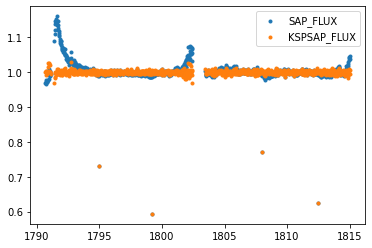

In [6]:
plt.scatter(lcfits[1].data['TIME'],lcfits[1].data['SAP_FLUX'],label='SAP_FLUX',marker='.')
plt.scatter(lcfits[1].data['TIME'],lcfits[1].data['KSPSAP_FLUX'],label='KSPSAP_FLUX',marker='.')
plt.legend()

There are some notably low flux measurements, but they appear to be individual data points, not prolonged transits or eclipses. We will investigate these more below.

Is this enough information to find our eclipse? By eye, it looks like this lightcurve spans about 25 days. Let's confirm.

In [7]:
print(np.max(lcfits[1].data['TIME'])-np.min(lcfits[1].data['TIME']))

24.33334324027419


The period of our stellar system as determined by the radial velocity method was about 84 days, but one individual QLP lightcurve only spans about 25 days. It would be best to make use of the multiple datasets available. As our analysis needs get more complicated, it's best to turn to a package that has our downloading, plotting, and analysis tools built in: `lightkurve`.

## Exercise 1

Use the documentation linked above and the [FITS Headers](https://docs.astropy.org/en/stable/io/fits/usage/headers.html) documentation from astropy to answer the following questions:
1. Is the magnitude of this target included, and if so, what is it?
2. Is the mass of this target included, and if so, what is it? 
3. What was the mass determined in the RV catalog? (You'll need to go back to Part 1 of the tutorial to complete this step!)

In [8]:
# Place for code for Exercise 2
# My solutions for Exercise 2:
print(lcfits[0].header['TESSMAG'])
print(lcfits[0].header['MASS'])
# The magnitude is 13.3269. 
# The mass is NOT included in the catalog. The mass from the RV catalog is 1.2 stellar masses.

13.3269
-1.0


# Combining Multiple Lightcurve Products using lightkurve
The Lightkurve package can also search the MAST archive and download all lightcurve products associated with a target stellar system. As we'll see, this package also is build specifically to plot and work with lightcurves in ways that will be eaiser than the `matplotlib` plotting we were doing above. This portion of the tutorial is based on lightkurve's [Combining multiple quarters of Kepler data](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-1-combining-multiple-quarters.html) tutorial.

In [9]:
search_result=lk.search_lightcurve(coordstring,author="QLP")
print(search_result)

SearchResult containing 4 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 18 2019    QLP    1800   373283207      0.0
  1 TESS Sector 19 2019    QLP    1800   373283207      0.0
  2 TESS Sector 24 2020    QLP    1800   373283207      0.0
  3 TESS Sector 25 2020    QLP    1800   373283207      0.0


## Downloading the lightcurves

In [10]:
lc_collection=search_result.download_all()
lc_collection

LightCurveCollection of 4 objects:
    0: <TessLightCurve LABEL="TIC 373283207" SECTOR=18 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    1: <TessLightCurve LABEL="TIC 373283207" SECTOR=19 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    2: <TessLightCurve LABEL="TIC 373283207" SECTOR=24 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    3: <TessLightCurve LABEL="TIC 373283207" SECTOR=25 AUTHOR=QLP FLUX_ORIGIN=sap_flux>

By choosing download_all, we create `LightCurveCollection` (basically, an array) of LightCurve products. By examining the first index in the collection, we can see that the columns are the same as in the .fits file that we downloaded thorugh `astroquery`, above. 

In [11]:
lc_0=lc_collection[0]
lc_0

time,flux,flux_err,cadenceno,sap_flux,kspsap_flux,kspsap_flux_err,quality,orbitid,sap_x,sap_y,sap_bkg,sap_bkg_err,kspsap_flux_sml,kspsap_flux_lag
,,,,,,,,,pix,pix,,,,
Time,float32,float32,int32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32
1790.6801864393085,0.9677138924598694,0.0036979245487600565,27034,0.9677139,1.0017732,0.0036979245,4096,43,171.42013549804688,1276.1275634765625,623.68,1048.87,1.000957,1.0035249
1790.70102002479,0.971984326839447,0.0036979245487600565,27035,0.9719843,1.0031046,0.0036979245,4096,43,171.41783142089844,1276.1309814453125,179.44,1076.92,1.0003365,1.0048736
1790.721853608647,0.9647804498672485,0.0036979245487600565,27036,0.96478045,0.993276,0.0036979245,4096,43,171.419189453125,1276.129638671875,446.8,1027.99,0.9969646,0.9932044
1790.742687191012,0.9723438620567322,0.0036979245487600565,27037,0.97234386,0.9992326,0.0036979245,4096,43,171.41798400878906,1276.1304931640625,290.9,862.25,1.0009333,0.99838513
1790.7635207718536,0.977621853351593,0.0036979245487600565,27038,0.97762185,1.0033098,0.0036979245,4096,43,171.4188232421875,1276.1298828125,148.66,1082.57,1.003577,1.0015497
1790.784354351268,0.9709927439689636,0.0036979245487600565,27039,0.97099274,0.995568,0.0036979245,4096,43,171.41729736328125,1276.1287841796875,261.52,1067.28,0.99910975,0.9963929
1790.8051879292327,0.9756560325622559,0.0036979245487600565,27040,0.97565603,0.99971545,0.0036979245,4096,43,171.4173583984375,1276.13037109375,196.66,1277.33,1.0011214,0.99924755
1790.826021505839,0.9727867245674133,0.0036979245487600565,27041,0.9727867,0.99636143,0.0036979245,4096,43,171.41822814941406,1276.1300048828125,292.17,1209.57,0.997881,0.9970241


## Plotting the lightcurves
We can use lightkurve's built in plotting feature to assure ourselves that we have downloaded the same dataset as we did above with ```astroquery```. This also helps us confirm that the default column to plot is ```sap_flux```; it is best for stellar variability, but not eclipses or transits. We must be sure to specify that we want to use ```kspsap_flux``` from now on.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='kspsap_flux'>

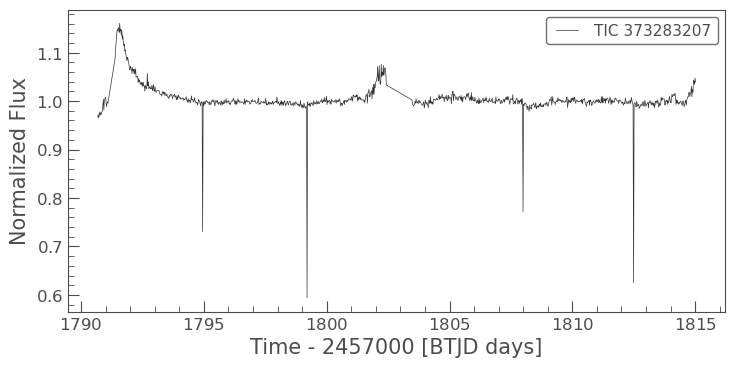

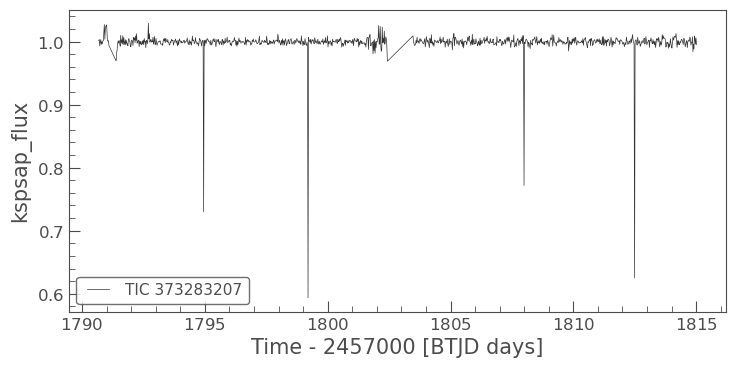

In [12]:
lc_0.plot()
lc_0.plot(column='kspsap_flux')

To combine all datasets as one, we can use the built-in stitching method.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='kspsap_flux'>

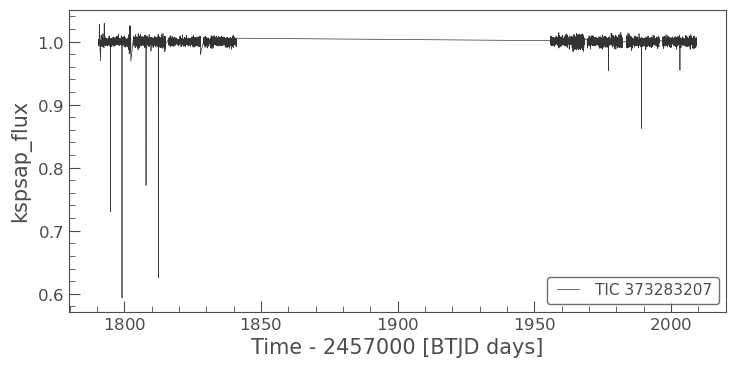

In [13]:
lc_stitched=lc_collection.stitch()
lc_stitched.plot(column='kspsap_flux')

Examining the full amount of data available, we can see that two datasets were taken approximately back-to-back, then there was a pause of over 100 days, and then another two datasets were taken (also approximatley back-to-back). 

It's tempting to look at some of this dips as transits or eclipses in the data! However, the non-zero values in the `quality` column are worth investigating. The tutorial [Instrumental Noise in Kepler and K2 /#1: Data Gapas and Quality Flags](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-2-kepler-noise-1-data-gaps-and-quality-flags.html), though specific to Kepler and not TESS, is still useful to consult. It provides a way to investigate "decode" each flag. We'll also investigate how many rows in our datatable contain each type of flag.

In [14]:
for flag in np.unique(lc_stitched.quality):
    print(flag, lk.KeplerQualityFlags.decode(flag))
    print('Number of datapoints with flag '+str(flag)+': '+str(np.sum(lc_stitched.quality==flag)))

0 []
Number of datapoints with flag 0: 3858
4096 ['Argabrightening on CCD']
Number of datapoints with flag 4096: 786


From the above, we can see that about 17% of our rows contain the "Argabrightening on CCD" flag. What do our lightcurves look like if we only plot the rows whose quality flag = 0?

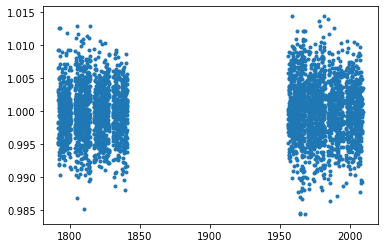

In [15]:
plt.scatter(lc_stitched['time'][lc_stitched['quality']==0].value,
         lc_stitched['kspsap_flux'][lc_stitched['quality']==0],marker='.')

As suspected, the notable dips are gone, as they were spurious individual data points rather than transits or eclipses. We'll still continue to use the tools in `lightkurve` to discover if there are any periodic changes to the lightcurve that might not be noticeable to our eyes. 

## Finding the Period of the Variability using lightkurve

Could the same 84 day period computed with the APOGEE dataset be present in our data?

`lightkurve` has built-in methods for finding the periodicity embedded in the lightcurve; the result is what's known as a periodogram. This portion of the tutorial is based off of the [What are Periodogram objects?](https://docs.lightkurve.org/tutorials/1-getting-started/what-are-periodogram-objects.html#What-are-Periodogram-objects?) and [Creating periodograms and identifying significant peaks](http://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html) tutorials; the second link in particular has more background information about the mathematics behind periodograms.

By default, the methods below will use the lc_stitched.flux property. As we saw above, by default, this is the ```sap_flux``` column. Before we continue, we will set this to match the ```kspsap_flux``` columns instead (and likewise, we will replace flux_err and the metadata key that notes the flux origin).

Next, we create the periodogram object (```pg```) and plot it.

In [16]:
lc_stitched.flux=lc_stitched['kspsap_flux']
lc_stitched.flux_err=lc_stitched['kspsap_flux_err']
lc_stitched.meta['FLUX_ORIGIN']='kspsap_flux'

In [17]:
# JRK this was a cludgy way to force the built-in methods of lightkurve to not use the 
# flagged data. It worked for the periodogram, but then breaks the folded lightcurve.
# Is it a problem to allow lightkurve to use all the data for the periodogram? 
# There is already some filtering happening because I saw that:
# ""By default, Lightkurve downloads quality-masked data. This means that a variety of 
# cadences with a non-zero quality flag will already be removed from the light curves or 
# TPFs you download using the instruction above.""
#  From: https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-2-kepler-noise-1-data-gaps-and-quality-flags.html
#lc_stitched.flux[lc_stitched['quality']!=0]=np.nan
#lc_stitched.flux_err[lc_stitched['quality']!=0]=np.nan
#lc_stitched.time[lc_stitched['quality']!=0]=np.nan
#lc_stitched.plot()

<AxesSubplot:xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power'>

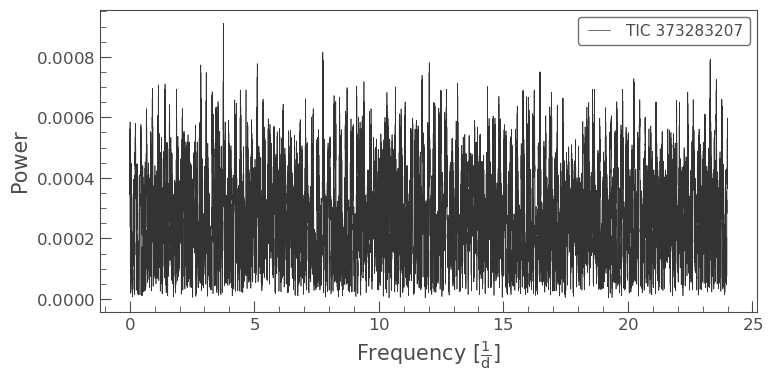

In [18]:
pg=lc_stitched.to_periodogram()
pg.plot()

For the types of periods we are interested in (measured in multiple days), the frequency will be very small, so the view above may not be insightful. Below, we  plot the periodogram with the period on the horizontal axis (instead of frequency) and with both axes in a logarithmic scale. 

On top of the plot, we'll include a vertical line that corresponds with the measured period from Price-Whelan+ 2018 and a dashed vertical line that corresponds to the "Period at Max Power" determined by the periodogram. 

PW+ 2018 period: 83.66193 days
Period at Max Power: 0.2656121595264303 d


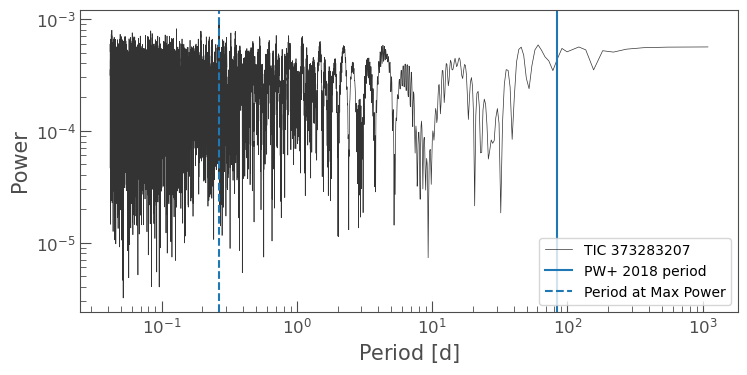

In [19]:
ax=pg.plot(view='period',scale='log')
ax.axvline(per,label='PW+ 2018 period')
ax.axvline(pg.period_at_max_power.value,label='Period at Max Power',linestyle='--')
ax.legend()
print('PW+ 2018 period: '+str(per)+' days')
print('Period at Max Power: '+str(pg.period_at_max_power))

The two periods do not match, and in fact, no clear period is found in the periodogram.

One way to check the veracity of a period is to plot the folded light curve. In a folded lightcurve, phase (in Julian days) appears on the horizontal axis instead of time. In other words, the observations are placed by where they appear in the periodic nature of the change. We can try to view the folded lightcurve assuming an 83.7 day period.

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

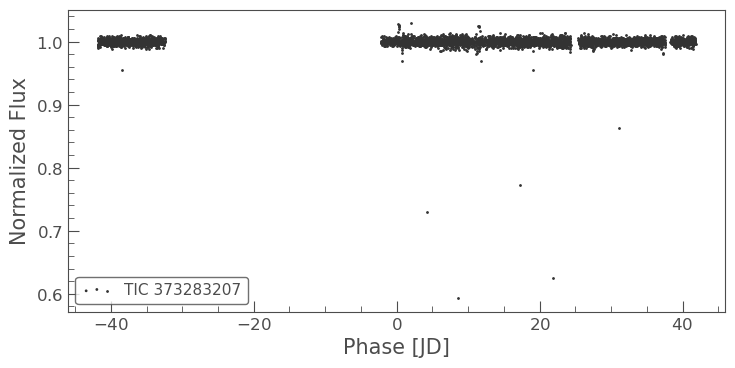

In [20]:
lc_stitched.fold(period=per).scatter()

Unfortunately, no clear eclipse is visible on that timescale. Though this example didn't yield an observable eclipse, there are many (nearly 5000!) candidate binary systems identified through the radial-velocity method that may have eclispes observed by TESS! The TASOC and QLP archives contain already processed light curves ready for exploration and discovery. 

## Additional Exercises

1. In Part 1 of the tutorial, `find _eclipse_candidates`, we created a for loop to search for TASOC and QLP observations using astroquery.mast Observations. Load the same `tbl` variable from that tutorial (a filtered version of [Price-Whelan et al. 2018 (AJ, 156, 1, 18)](https://ui.adsabs.harvard.edu/abs/2018AJ....156...18P/abstract) Table 4a, and create a loop to search for TASOC and QLP observation using lk.search_lightcurve instead. Which is faster? 
2. Choose another stellar system from PW+2018, plot the stitched lightcurve, and create the periodogram. Compare the period at maximum power found to the period derived from the radial velocity method.

In [21]:
# Place for code for Exercise 1
# JRK need to do the solution

In [22]:
# Place for code for Exercise 2
# JRK need to do the solution

## About this Notebook

**Author:** Julia Kamenetzky, ScienceBetter Consultant 
(JRK what email address to put?)

**Updated On:** 2022-07-07

## Citations

If you use `astropy`, `astroquery`, `lightkurve`, or `VizieR` for published research, please cite the
authors. Follow these links for more information about citing these tools:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* If you use astroquery, please cite the paper [Ginsburg, Sipőcz, Brasseur et al 2019](https://ui.adsabs.harvard.edu/abs/2019AJ....157...98G/abstract).
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)
* [Citing `VizieR`](https://cds.unistra.fr/vizier-org/licences_vizier.html?#copyrightvizier)


***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 